# Basic usage of the delphi toolbox

In [1]:
import os
import torch

## 1. Installing the delphi package

The delphi toolbox currently needs to be installed manually. </br>

## 2. Using the NiftiDataset and PyTorch DataLoader class to load data

In [2]:
from torch.utils.data import DataLoader
from delphi.utils.datasets import NiftiDataset
from delphi.utils.tools import ToTensor

I recommend using the same structure for your data as shown in the figure below. <br/>
This indicates that there are three classes each containing 4 subjects within the training and testing data splits and makes it easy using certain code to determine, for example, the class labels. 

<img src="./figs/data_struct.png" width="100" height="200" style="margin:auto"/>

The following list describes which variables you should set to be able to easily use the `NiftiDataset`class.
1. Set the paths to the test and training set (see `path_to_train_data` below).
2. Define the names of the classes (i.e., the class labels) you would like to use for your training and testing.
3. Define which device (i.e., the cpu or gpu) you would like to use to train your model. This is important since the data and the model are required to be used by the same device. Otherwise the code will result in an error. Keep this in mind!
4. Assign all variables to the `NiftiDataset` class and define in the class call how many samples from your dataset you want to use. Tipp: If you want to use ALL data in the respective class directories use the value `0`.
5. You will encounter a `ToTensor()` command in the code block below. The data and labels need to be saved in a so-called PyTorch Tensor format. The `transform=ToTensor()` takes care of that for you.
    

In [3]:
# Step 1
path_to_train_data = './data/train_split' # where is the training data located
path_to_test_data = './data/test_split' # where is the test data located

# Step 2
classes_to_load = ['class1', 'class2', 'classN'] # which classes should be loaded

# Step 3
device = torch.device('cpu') # on which hardware (cpu/gpu) should the data be used

# Step 4
# NiftiDataset(path_to_train_data, classes_to_load, #_files_to_load, device, transform=ToTensor())
dataset = NiftiDataset(path_to_train_data, classes_to_load, 2, device, transform=ToTensor())

The `dataset` structure/class contains a few important attributes (i.e., variables):
1. `dataset.classes` provides the classes you set equal to `classes_to_load`
2. `dataset.data` provides the paths to the data. 
3. `dataset.labels` provides the data-label mapping. 
4. `dataset.dims` provides the dimensions of the data (default: 3)

Alright. Let us now look at what the we have stored in the `dataset` class. </br>
We can access the saved variables with the `.` indicator, e.g., `dataset.classes` will provide us with the information which classes the dataset contains. Note: these should be identical to the variable `classes_to_load` that we set before. </br>
You might be wondering if we can use strings as labels. The quick answer is: no. BUT the `NiftDataset` class, for now, only holds information about the data we want to use. The labels will be transformed into numbers when single/multiple datapoints are indeed loaded. The code block below demonstrates how this works.
</br>

In [4]:
# show us some variables of the dataset
print('Classes of the data:', dataset.classes)
print('\nPaths to the data: ', dataset.data)
print('\nLabels: ', dataset.labels)

# let us load a single entry in the 'dataset' variable.
# the function .__getitem__ is automatically called when the variable is used in a loop
# as shown further below. Here we simply want to demonstrate that the data and label 
item, label = dataset.__getitem__(0)
print('\nShape of the loaded item:', item.shape, '\nLabel of the loaded item:', label, '\n')

# if we wanted to loop over the entire dataset we can do the following:
print('Loading data using NiftiDataset')
for counter, (item, label) in enumerate(dataset):
    # counter is the current loop iteration (starts at 0)
    # item is the current item in the dataset, label the respective label
    print('Entry', counter, item.shape, label)

print('\n')
    
# Pytorch comes with handy functionality for data loading. We can supply the NiftiDataset
# to this functionality as well and it is recommended doing so since other functions 
# such as the fit() function will require you to supply a PyTorch DataLoader
nifti_loader = DataLoader(dataset, batch_size=2, shuffle=True)
print('Loading data using the PyTorch DataLoader supplied with the NiftiDataset')
for counter, (items, labels) in enumerate(nifti_loader):
    # in this example we load two items and two labels at once
    # the number is determined by the batch_size we set in the DataLoader
    print('Entry', counter, items.shape, labels)

Classes of the data: ['class1', 'class2', 'classN']

Paths to the data:  ['./data/train_split/class1/sub100206.nii.gz'
 './data/train_split/class1/sub102614.nii.gz'
 './data/train_split/class2/sub100206.nii.gz'
 './data/train_split/class2/sub102614.nii.gz'
 './data/train_split/classN/sub100206.nii.gz'
 './data/train_split/classN/sub102614.nii.gz']

Labels:  ['class1' 'class1' 'class2' 'class2' 'classN' 'classN']

Shape of the loaded item: torch.Size([1, 91, 109, 91]) 
Label of the loaded item: tensor(0) 

Loading data using NiftiDataset
Entry 0 torch.Size([1, 91, 109, 91]) tensor(0)
Entry 1 torch.Size([1, 91, 109, 91]) tensor(0)
Entry 2 torch.Size([1, 91, 109, 91]) tensor(1)
Entry 3 torch.Size([1, 91, 109, 91]) tensor(1)
Entry 4 torch.Size([1, 91, 109, 91]) tensor(2)
Entry 5 torch.Size([1, 91, 109, 91]) tensor(2)


Loading data using the PyTorch DataLoader supplied with the NiftiDataset
Entry 0 torch.Size([2, 1, 91, 109, 91]) tensor([1, 2])
Entry 1 torch.Size([2, 1, 91, 109, 91]) tenso

</br>
That is already it! Quite simple, I hope. In practice you only have to define the parameters for the `NiftiDataset` and `DataLoader` classes. The loop you saw at the end is already implemented in the default training function of the `delphi` toolbox. <br/>
However, if you were to write your own training function you would need to implement this function for yourself. Thus, we wanted to at least provide you with an example of how to do it here.
</br>

## 3. Creating a simple 3D-CNN

Let us now recreate a very simple convolutional neural network from my dissertational work that can handle 3-dimensional input, such as neuroimaging data. An illustration of the network is shown below:</br>

<img src="./figs/architecture.svg" style="margin:auto">

We will use the `BrainStateClassifier3d` from th `delphi.networks.ConvNets` subpackage. 

In [5]:
from delphi.networks.ConvNets import BrainStateClassifier3d
from torchinfo import summary # don't worry about this for now, this is to nicely print what our network looks like

There are multiple ways in which one can instantiate a `BrainStateClassifier3d` network. For now, we will stick with the simplest case. <br/>
We will first define a configuration python `dict`. The code block below demonstrates how to do this. The goal is to have a CNN that takes a single whole-brain dataset as its input. The network it self is supposed to have 4 convolutional and 2 linear layers. We can do this by defining 2 important entries in the dictionary: the `channels` and `lin_neurons` entries as shown below:

In [6]:
network_config = {
    'channels': [1, 8, 16, 32, 64],
    'lin_neurons': [128, 64]
}

These two lines represent the following:
1. the `channels` entry conveys multiple meanings: <br/>
First: the first number (here) `1` represents the input channels to the network. Since we said that we only want a single brain volume as input the number is `1` </br>
Second: the remaining 4 numbers have two meanings. 1) the number of elements after the `1` tell the `BrainStateClassifier3d` class how many convolutional layers there should be in succession, and 2) the value of the numbers tell the `BrainStateClassifier3d` class how many filters the respective convolutional layer is supposed to have. 
2. the `lin_neurons` entry conveys a similar meaning, however, here the number of elements (i.e., 2) tells the `BrainStateClassifier3d` class how many linear (i.e., fully-connected) layers it is supposed to instantiate and with how many nodes (determined by the value of the numbers).

Now, to create the `BrainStateClassifier3d` network, we also need to supply it information about the dimensions of the input data how many classes it needs to identify. The `input_dimensions` should be a tuple-type variable as seen in the code block below. The number of classes can easily be determined by the length of the classes variable (e.g., `classes_to_load` or `dataset.classes`).

The code block below shows how to set these two variables.

In [7]:
input_dimensions = (91, 109, 91)
n_classes = len(dataset.classes)

Now it is time for us to create the 3d-CNN! Only one single additional line of code is necessary to do so:

In [8]:
network = BrainStateClassifier3d(input_dimensions, n_classes, network_config) 

That's it. Really. That really is it :-). 

Now, let us look what actually happened. The `network` class has two important features we need to take a look at: 

1. `network.config`: This attribute summarizes the values of the created network and we will take a look at this in a second.
2. `network.fit()`: This function calls the default training function supplied by the delphi toolbox.

In [9]:
# Let us first take a look at the network.config attribute
network.config

{'channels': [1, 8, 16, 32, 64],
 'lin_neurons': [128, 64],
 'kernel_size': [5, 5, 5, 5],
 'pooling_kernel': 2,
 'dropout': 0.5,
 'input_dims': (91, 109, 91),
 'n_classes': 3,
 'train_fn': <function delphi.utils.train_fns.standard_train(model, train_data: torch.utils.data.dataloader.DataLoader, loss_fn=CrossEntropyLoss(), optimizer=<class 'torch.optim.adam.Adam'>, lr: float = 1e-05, device: torch.device = device(type='cpu'), train=True, **optimizer_kwargs) -> Tuple[numpy.ndarray, numpy.ndarray]>,
 'last_cnn_dims': [5, 6, 5]}

Ok, so we have some more information here!
1. We see that the `channels` and `lin_neurons` elements are there as we set them.
2. We see additional variables:</br>
`kernel_size`: This variable describes the dimensions of the filters for the respective CNN-layer. And they seem to be set to the value '5' for all of them.</br>
`pooling_kernel`: This is the factor by how much a pooling layer, that currently is always following a CNN-layer, decreases the current dimensions of the input. </br>
`droput`: is a regularization variable important for the learning process and I recommend reading up on it. </br>
`train_fn`: is a function handle to the default training function supplied by the delphi toolbox.</br>
`last_cnn_dims`: is a variable that is not directly necessary for us to know but important for the internal workings of the code. It is here in case you need to double check if the output dimensions fit your expectations in the case you need to debug something.

Every additional attribute/function you see above are the default settings for the delphi toolbox and can be overwritten as you wish. We will see how this works now.

There are two ways in which you can adapt the architecture of your network:
1. Use a `dict` variable as shown above
2. Use a `.yaml` file as you can see in the `example_config.yaml` file in this tutorial directory.

### 3.1. Using a dict variable

Let us first just change a few things:
1. 5 CNN-layers instead of 4
2. 3 linear-layers instead of 2
3. a kernel_size of 7 instead of 5
4. change the dropout to .3 instead of .5

In [10]:
network2_config = {
    'channels': [1, 4, 8, 16, 16, 32], # you can change the number of filters how ever you like them
    'lin_neurons': [128, 256, 128], # same goes for the number of nodes. Be aware that some settings may make less sense than others
    'kernel_size': 7,
    'dropout': .3,
}

network2 = BrainStateClassifier3d(input_dimensions, 3, network2_config)
network2.config

{'channels': [1, 4, 8, 16, 16, 32],
 'lin_neurons': [128, 256, 128],
 'kernel_size': [7, 7, 7, 7, 7],
 'pooling_kernel': 2,
 'dropout': 0.3,
 'input_dims': (91, 109, 91),
 'n_classes': 3,
 'train_fn': <function delphi.utils.train_fns.standard_train(model, train_data: torch.utils.data.dataloader.DataLoader, loss_fn=CrossEntropyLoss(), optimizer=<class 'torch.optim.adam.Adam'>, lr: float = 1e-05, device: torch.device = device(type='cpu'), train=True, **optimizer_kwargs) -> Tuple[numpy.ndarray, numpy.ndarray]>,
 'last_cnn_dims': [2, 3, 2]}

Cool. But you may want to be even more specific in defining your network. Say, you want to have different filter sizes for each convolutional layer. Fear not, this is in fact possible like so:

In [11]:
network3_config = {
    'channels': [1, 8, 8, 64],
    'kernel_size1': 7,
    'kernel_size2': 5, 
    'kernel_size3': 3,
    'lin_neurons1': 128,
    'lin_neurons2': 128,
}

network3 = BrainStateClassifier3d(input_dimensions, 3, network3_config)
network3.config

{'channels': [1, 8, 8, 64],
 'lin_neurons': [128, 128],
 'kernel_size': [7, 5, 3],
 'pooling_kernel': 2,
 'dropout': 0.5,
 'input_dims': (91, 109, 91),
 'n_classes': 3,
 'train_fn': <function delphi.utils.train_fns.standard_train(model, train_data: torch.utils.data.dataloader.DataLoader, loss_fn=CrossEntropyLoss(), optimizer=<class 'torch.optim.adam.Adam'>, lr: float = 1e-05, device: torch.device = device(type='cpu'), train=True, **optimizer_kwargs) -> Tuple[numpy.ndarray, numpy.ndarray]>,
 'last_cnn_dims': [11, 13, 11]}

I hope this example shows how easy it is to be more specific in the definition. Although it should be noted that the `kernel_sizeX` attribute is the most flexible in the current version of delphi. It should also be noted that currently the `BrainStateClassifier3d` can not be a fully convolutional neural network (FCN). This will be implemented in future versions of the toolbox. 

### 3.2. Using a .yaml file

As mentioned above you can also use a `.yaml` file to configure your architecture.
For this you will need the `read_config` function from the `delphi.utils.tools` subpackage. The `read_config` function simply takes a path to a .yaml file as input. It then reads the contents of that file and converts it into a python `dict` format that should resemble the one we set manually in the code block above.

In [12]:
from delphi.utils.tools import read_config

In [13]:
read_config('example_config.yaml')

{'channels': [1, 8, 8, 64],
 'kernel_size1': 7,
 'kernel_size2': 5,
 'kernel_size3': 3,
 'lin_neurons1': 128,
 'lin_neurons2': 128}

And it does. Fantastic. Now, the reason why I implemented different ways to configure the neural networks is that a very useful tool to perform so called `hyperparameter tuning` (weights&biases) uses yaml files to set parameters. While using the delphi toolbox in combination with weights&biases is a little more complex, the delphi toolbox provides you with some functionality to reduce this complexity. An example how to use weights&biases with the delphi toolbox is in another jupyter notebook.

### 3.3. Saving a network state

In [14]:
# 1. We save the state_dict of our configured model
network.save('./saved_models/my_model')
# This creates a directory <my_configured_model> at the location <path/to>
# Within this directory you will find a <state_dict.pth> and <config.yaml> file.

# loading the model. Note that in this case you effectively create a "new" network and then fill its weights
# and biases with the state_dict you saved before. This requires you to import the model class!
loaded_model = BrainStateClassifier3d('./saved_models/my_model')

#######################################################################################################################

# 2. We save the entirety of our configured model
network.save('./saved_models/my_model_2', save_full=True)

# Using loading approach does not require you to import the SimpleLinearModel class
# in a different python file for example. 
loaded_model = torch.load('./saved_models/my_model_2/model.pth')

Saving ./saved_models/my_model/state_dict.pth
Loading from config file ./saved_models/my_model/config.yaml
Saving entire model ./saved_models/my_model_2/model.pth


Let us now do the last step: Training the neural network!

## 4. Training the neural network

Shown below is the default training function of the `delhi` toolbox. Take a look at it. It is extensively commented and should provide a clear picture of how a 'standard' training function is structured. It may seem daunting for someone with little programming experience but I promise you, it is not too bad.

```python
def standard_train(
        model,
        train_data: DataLoader,
        loss_fn=CrossEntropyLoss(),
        optimizer=Adam, lr: float = .00001,
        device: torch.device = torch.device("cpu"),
        train=True,
        **optimizer_kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    r"""
    A simple function to train a supplied neural network for multiclass problems.

    Args:
        model: only necessary if this function is not supplied to the model constructor. Otherwise model.fit()
            calls the function with model=self
        train_data (DataLoader): dataloader used for training or validation/test if function is called in model.eval()
            context
        loss_fn: loss function to use (default: CrossEntropyLoss)
        optimizer: optimizer to use to adjust weights in backward pass (default: Adam)
        lr (float): the learning rate for the optimizer
        device (torch.device): do computations on device, e.g., cpu or gpu (default: cpu)
        train (bool): set the network into training mode (True|default) or evaluation (False)
        **optimizer_kwargs: additional arguments for the supplied optimizer

    Returns:
        Tuple[epoch_loss, stats]: the stats variable contains multiple values. The first 0:n_classes columns contains
        the classification probability for a given input (row). The second to last column (i.e., stats[:,-2]) contains
        the predicted label. The last column (i.e. stats[:, -1] contains the real label.

    """

    # set the model into training mode if it is not and train=True
    if train:
        if not model.training:
            model.train()
    else:
        model.eval()

    # here is something new: the optimizer
    # The optimizer determines the algorithm with which the weights of the layers
    # are adjusted. Here we use the 'Adam' algorithm by default.
    optimizer = optimizer(model.parameters(), lr=lr, **optimizer_kwargs)

    epoch_loss = 0

    # the batch loop. Within this loop we iterate over all samples stored in the
    # train_data variable.
    # the variable 'batch' represents the current iteration [integer value]
    # the variable 'inputs' is the actual input data in the shape of batch_size-by-inputshape
    # the variable 'labels' contains the respective class label
    for batch, (inputs, labels) in tqdm(enumerate(train_data)):

        # in this function we transfer the data and the label tensors to the chosen device
        # NOTE: I RECOMMEND TRANSFERING THE DATA AND LABELS TO THE DEVICE WHEN YOU LOAD THEM
        # MORE ON THIS IN A DIFFERENT STEP THOUGH [see DataSets and DataLoaders)
        #inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = inputs, labels

        # reset the gradients
        # a crucial step in training the networks. Otherwise the gradients accumulate after
        # each batch iteration and weird stuff will happen.
        if model.training:
            for p in model.parameters():
                p.grad = None

        outputs = model(inputs.float())  # forward pass through model

        loss = loss_fn(outputs.squeeze(), labels.squeeze())  # calculate loss

        # in this statement we check if the network is currently in training mode,
        # which means, that every layer in the network has the required_grad flag set
        # to True. This in turn means that the backpropagation algorithm is executed.
        # If the model, however, is not in training mode we do not want to exectue
        # the backward pass and we also do not want to store the so-called pytorch graph.
        if model.training:
            loss.backward()  # do a backward pass
            optimizer.step()  # update parameters

        # get the probabilities of the predictions
        prediction_probs = model.SM(outputs.data).cpu().numpy()
        # get the label number of the output
        _, predicted_labels = torch.max(outputs.data, 1)

        epoch_loss += loss.item()  # sum up the loss over all batches

        # just a helper variable
        inter = np.hstack(
            [prediction_probs.squeeze(),
             labels.squeeze().cpu().numpy()[:, None],
             predicted_labels.squeeze().cpu().numpy()[:, None]]
        )
        stats = np.vstack([stats, inter]) if 'stats' in vars() else inter  # noqa

    return epoch_loss / len(train_data), stats  # noqa
```

Now, here is actually the point where some programming from your side is necessary because a training loop can be different for each project, which makes it difficult to standardize. Usually a neural network is trained iteratively. We call these training iterations `epochs`. One epoch is finished, after the neural network has seen all elements of the dataset. A standard training loop looks something like this:

In [15]:
# 1. load the neural network we want to train
network = BrainStateClassifier3d('./saved_models/my_model')

Loading from config file ./saved_models/my_model/config.yaml


In [16]:
# 2. set up the data. Remember, we did this at the beginning of this notebook, but we will reiterate here how it works.
# define the paths to the data
path_to_train_data = './data/train_split' # where is the training data located
path_to_test_data = './data/test_split' # where is the test data located

# define the classes
classes_to_load = ['class1', 'class2', 'classN'] # which classes should be loaded

# set the device on which we want to compute everything
device = torch.device('cpu') # on which hardware (cpu/gpu) should the data be used

# instantiate the dataset and dataloader
dataset = NiftiDataset(path_to_train_data, classes_to_load, 2, device, transform=ToTensor())
test_dataset = NiftiDataset(path_to_test_data, classes_to_load, 2, device, transform=ToTensor())

loader = DataLoader(dataset, batch_size = 2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 2, shuffle=True)

In [17]:
from delphi.utils.tools import compute_accuracy
import pandas as pd

In [18]:
# Now, let us do the training loop!
# There may be things that you are not so familiar with, 
# but dont worry, these things will come quite quickly
# Also, don't be fooled by the length of this code block.
# Without all those comments the actual number of lines is quite low

#1. let's define for how many epochs we want to train
n_epochs = 25

# set some variables to save loss and accuracy curves etc.
# we can use these variables to make pretty graphs showing us
# how well/fast the network learned and how well it performes
# over training time
loss_acc = []
train_stats, valid_stats = [], []

#2. loop over these epochs
for epoch in range(n_epochs):
    #to train the network, we call its .fit function
    #The .fit() function by default calls the standard_train
    #function as defined above. We therefore need to supply some variables.
    #Additionally, we get two outputs from the train function: the loss, and some stats
    _, _ = network.fit(loader, device=device, train=True) # note, we could also change the learning rate if we wanted

    # for validating or testing set the network into evaluation mode such that layers like dropout are
    # not active. This is important because if we were to compare the validation/test curves with those
    # of the training curve while dropout is still active, we would likely see the validation/test
    # data to be better classified than the training data. And that should NEVER be the case.
    with torch.no_grad():
        tloss, tstats = network.fit(loader, device=device, train=False)
        vloss, vstats = network.fit(test_loader, device=device, train=False)

    # the model.fit() method has 2 output parameters: loss, stats = model.fit()
    # the first parameter is simply the loss for each sample
    # the second parameter is a matrix of n_classes+2-by-n_samples
    # the first n_classes columns are the output probabilities of the model per class
    # the second to last column (i.e., [:, -2]) represents the real labels
    # the last column (i.e., [:, -1]) represents the predicted labels
    tacc = compute_accuracy(tstats[:, -2], tstats[:, -1])
    vacc = compute_accuracy(vstats[:, -2], vstats[:, -1])
    
    # we can now assign all the output we got to some nice datastructure that makes plotting
    # and computing various stats really easy
    loss_acc.append(pd.DataFrame([[tloss, vloss, tacc, vacc]],
                                 columns=["train_loss", "valid_loss", "train_acc", "valid_acc"]))

    train_stats.append(pd.DataFrame(tstats.tolist(), columns=[*dataset.classes, *["real", "predicted"]]))
    train_stats[epoch]["epoch"] = epoch
    valid_stats.append(pd.DataFrame(vstats.tolist(), columns=[*dataset.classes, *["real", "predicted"]]))
    valid_stats[epoch]["epoch"] = epoch
    
    # lastly, we want some immediate output to see how the network performs
    print('Epoch=%03d, train_loss=%2.3f, train_acc=%1.3f, valid_loss=%2.3f, valid_acc=%1.3f' %
          (epoch, tloss, tacc, vloss, vacc))
    
# After the loop is done, we can convert the stat lists into so-called pandas dataframes for further processing.
df_loss_acc = pd.concat(loss_acc).reset_index(drop=True)
df_train_stats = pd.concat(train_stats)
df_valid_stats = pd.concat(valid_stats)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=000, train_loss=1.099, train_acc=0.333, valid_loss=1.100, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=001, train_loss=1.098, train_acc=0.333, valid_loss=1.099, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=002, train_loss=1.098, train_acc=0.333, valid_loss=1.100, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=003, train_loss=1.096, train_acc=0.333, valid_loss=1.098, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=004, train_loss=1.097, train_acc=0.333, valid_loss=1.099, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=005, train_loss=1.096, train_acc=0.333, valid_loss=1.099, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=006, train_loss=1.097, train_acc=0.333, valid_loss=1.100, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=007, train_loss=1.095, train_acc=0.333, valid_loss=1.098, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=008, train_loss=1.094, train_acc=0.333, valid_loss=1.097, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=009, train_loss=1.092, train_acc=0.333, valid_loss=1.096, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=010, train_loss=1.091, train_acc=0.333, valid_loss=1.095, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=011, train_loss=1.089, train_acc=0.333, valid_loss=1.093, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=012, train_loss=1.088, train_acc=0.333, valid_loss=1.093, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=013, train_loss=1.087, train_acc=0.333, valid_loss=1.091, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=014, train_loss=1.088, train_acc=0.333, valid_loss=1.093, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=015, train_loss=1.086, train_acc=0.333, valid_loss=1.091, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=016, train_loss=1.084, train_acc=0.333, valid_loss=1.088, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=017, train_loss=1.083, train_acc=0.333, valid_loss=1.087, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=018, train_loss=1.083, train_acc=0.333, valid_loss=1.089, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=019, train_loss=1.084, train_acc=0.333, valid_loss=1.089, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=020, train_loss=1.084, train_acc=0.333, valid_loss=1.089, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=021, train_loss=1.082, train_acc=0.333, valid_loss=1.088, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=022, train_loss=1.082, train_acc=0.333, valid_loss=1.087, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=023, train_loss=1.082, train_acc=0.333, valid_loss=1.088, valid_acc=0.333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch=024, train_loss=1.082, train_acc=0.333, valid_loss=1.089, valid_acc=0.333


### Let's plot some graphs

In [19]:
from delphi.utils.plots import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns # this is a cool toolbox to create beautiful plots using pandas dataframes

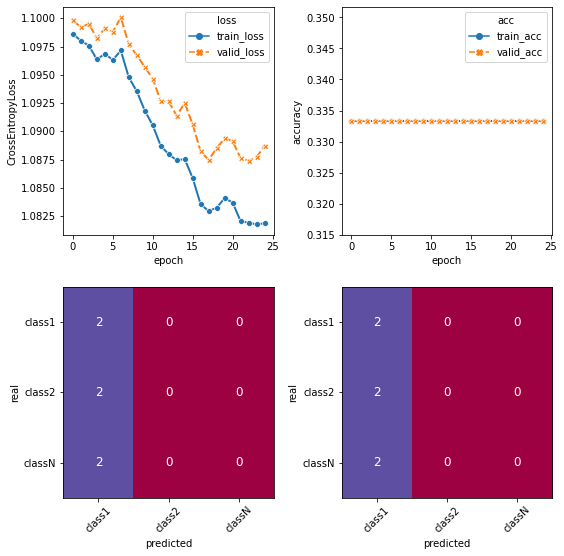

In [20]:
df_loss_acc["epoch"] = df_loss_acc.index
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
# plot the loss curves
sns.lineplot(ax=axes[0, 0], data=df_loss_acc.melt(value_vars=["train_loss", "valid_loss"], 
                                               id_vars="epoch", var_name="loss", value_name="CrossEntropyLoss"), 
             x="epoch", y="CrossEntropyLoss", style="loss", hue="loss", markers=True, markersize=6, linewidth=2);

# plot the accuracy curves
sns.lineplot(ax=axes[0, 1], data=df_loss_acc.melt(value_vars=["train_acc", "valid_acc"], id_vars="epoch", var_name="acc", value_name="accuracy"), 
             x="epoch", y="accuracy", style="acc", hue="acc", markers=True, markersize=6, linewidth=2);

# we can also check out the classification performance in form of confusion matrices
last_epoch_data = df_train_stats[df_train_stats.epoch == n_epochs-1]
confusion_matrix(last_epoch_data.real, last_epoch_data.predicted, dataset.classes, ax=axes[1,0]);

last_epoch_data = df_valid_stats[df_valid_stats.epoch == n_epochs-1]
confusion_matrix(last_epoch_data.real, last_epoch_data.predicted, dataset.classes, ax=axes[1,1]);

fig.tight_layout()

Now, the dataset in this example is obviously way to small to make any claims. It is afterall just to show how to use the toolbox. </br>
That's all for the basics of the delphi toolbox and I hope it became clear how usefull it can be :-).